# Week 8 - Multivariate Analysis

## Please run the cells of the notebook as you get to them while reading

In [172]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import decomposition
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Lesson: Multivariate graphs

In this lesson, we'll consider some multivariate plots: heatmaps and bubble plots.  We'll also consider principal component analysis and multiple regression.

### Heatmaps

In this plot, we use a heatmap to count the total traffic tickets given to citizens.  A heatmap requires the x and y axes to be categorical, while the color involves a third, numerical variable.  In this example, each row of the DataFrame represents a traffic ticket given to one person in a particular city and year.  The data are given as three columns (city, year, and ticket), so we must use a pivot_table to transform it into a two-dimensional grid.  The cmap is set to "Blues" in the first example, meaning that the heatmap uses only blue as its color.  However, we could also use a multicolor map like "viridis" in the second example.  I personally think "Blues" is easier to read - what do you think?  

#### **My Answer:**

I'm partial to the 'coolwarm' coloset myself (for utility/ readability), although it's not my favorite set of colors asthetically. 





Here is a reference guide to the color maps:


https://matplotlib.org/stable/gallery/color/colormap_reference.html

In [ ]:
np.random.seed(0)
num_samples = 100
city_series = np.random.choice(["New York", "Boston", "Atlanta", "Washington, D. C."], size = num_samples)
year_series = np.random.choice([2018, 2019, 2020], size = num_samples)
ticket_series = np.random.randint(50, 150, size = num_samples) # Traffic tickets can be from $50 to $150
df = pd.DataFrame({"city": city_series, "year": year_series, "ticket": ticket_series})


In [45]:
df.iloc[0:5] # first five rows of a long DataFrame

,city,year,ticket
0,New York,2019,79
1,"Washington, D. C.",2020,71
2,Boston,2018,75
3,New York,2018,130
4,"Washington, D. C.",2020,110


In [46]:
pivot = df.pivot_table(index = ["city"], columns = ["year"], values = "ticket", aggfunc = "sum")
pivot # 2 by 2 grid showing total ticket amounts

year,2018,2019,2020
city,,,
Atlanta,742,440,538
Boston,775,628,922
New York,1122,841,596
"Washington, D. C.",1258,451,1385


Text(0.5, 1.0, 'Total traffic tickets by city and year')

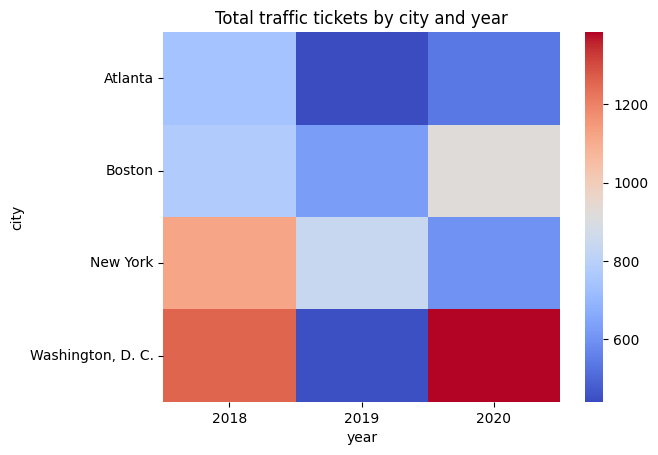

In [59]:
ax = sns.heatmap(pivot, cmap = "coolwarm")
ax.set_title("Total traffic tickets by city and year")

Text(0.5, 1.0, 'Average traffic ticket value by city and year')

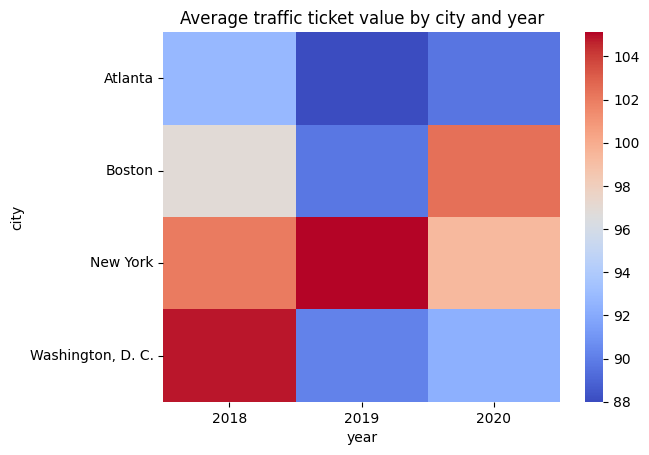

In [52]:
pivot2 = df.pivot_table(index = ["city"], columns = ["year"], values = "ticket", aggfunc = "mean") # note mean, not sum this time
ax2 = sns.heatmap(pivot2, cmap = "coolwarm") # do you think this is a better or worse scale than Blues?
ax2.set_title("Average traffic ticket value by city and year")

### Bubble plots

A bubble plot is just a scatter plot, but with the dot size representing a third variable.  Here, each data point shows a tree (I mean the kind of tree that is a plant and grows in the ground, not a decision tree), with its height, width of branches, and root depth.  The bubble size in the bubble plot represents the root depth, while the other variables are shown on the x and y axes.  From this plot, we can see that the root depth is strongly correlated with both the width of branches and the tree height.

Text(0, 0.5, 'width of branches')

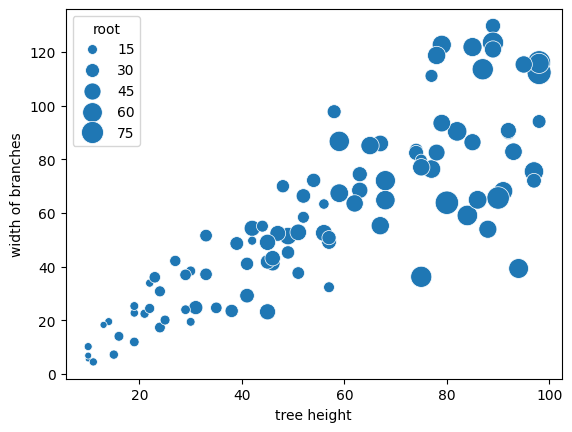

In [31]:
np.random.seed(0)
num_samples = 100
height_series = np.random.randint(10, 100, size = num_samples) # tree height
width_series = height_series * np.maximum(np.random.normal(scale = 0.3, loc = 1, size = num_samples), 0.25) # strongly related to height
root_series = height_series * np.maximum(np.random.normal(scale = 0.2, loc = 0.7, size = num_samples), 0.3) # strongly related to height
df2 = pd.DataFrame({'height': height_series, 'width': width_series, 'root': root_series})
minroot = root_series.min()
maxroot = root_series.max()
maxbubble = 300
ax = sns.scatterplot(data = df2, x = "height", y = "width", size = "root", sizes = (minroot / maxroot * maxbubble, maxbubble))
ax.set_xlabel("tree height")
ax.set_ylabel("width of branches")

### Principal Component Analysis

Principal Component Analysis can be thought of as a way to use one (or a few) linear combinations of the coordinates in order to explain all of the coordinates.  It is most useful when there are strong correlations between some or all of the coordinates.  Principal Component Analysis can show us which linear combinations are most (and least) useful for explaining the data.

With the trees data, the three values (height, width, and root) are highly correlated.  For this reason, Principal Component Analysis shows that most of the variance can be explained by a single value which is a linear combination of height, width, and root.  What this means is that if the first components_ vector in the code below (the "first principal component") is \[a, b, c\], for some specific numbers a, b, and c, then the value v = a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r), where the mu's are the means, is highly informative about the values of height, width, and root.  In this case, because height, width, and root are so highly correlated, we can almost assume that all of the data is located along an axis defined by the vector \[a, b, c\].  The point v * \[a, b, c\] + (mean vector) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (mean vector) is therefore approximately equal to the data point (height, width, root) in question.  The mean vector is \[mu_h, mu_w, mu_r\].  Importantly, there is still variance unexplained by this one value - just knowing v * \[a, b, c\] does not tell you the height, width, and root with 100% accuracy.  If the second principal component is \[d, e, f\], then we could approximate the tree vector even more accurately as: (height, width, root) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (d * (height - mu_h) + e * (width - mu_w) + f * (root - mu_r)) * \[d, e, f\] + (mean vector).

The printing of "components_", below, shows the first principal component \[a, b, c\].  If you draw a vector in the direction shown, you will be heading in the direction where the values height, width, and root change most rapidly.  A later computation shows all three principal component vectors.

**Optional exercise for the reader:** show that if all three principal components are included, then equality is exact.  This is going to be true simply because the principal components are orthonormal: the projections onto a complete set of orthonormal vectors always add up to the original vector.

(height, width, root) = (a * (height - mu_h) + b * (width - mu_w) + c * (root - mu_r)) * \[a, b, c\] + (d * (height - mu_h) + e * (width - mu_w) + f * (root - mu_r)) * \[d, e, f\] + (g * (height - mu_h) + h * (width - mu_w) + i * (root - mu_r)) * \[g, h, i\] + \[mu_h, mu_w, mu_r\].

For this proof, we must use the fact that the principal component vectors are orthonormal.  That is, any pair of them are orthogonal, even with a transpose (ad + be + cf = 0, ag + bh + ci = 0, dg + eh + fi = 0, ab + de + gh = 0, ac + df + gi = 0, bc + ef + hi = 0) and any one of them is a unit vector, even with a transpose (a^2 + b^c + c^2 = 1, d^2 + e^2 + f^2 = 1, g^2 + h^2 + i^2 = 1, a^2 + d^2 + g^2 = 1, b^2 + e^2 + h^2 = 1, c^2 + f^2 + i^2 = 1).  If you write out the equation above as a single vector, then apply the orthonormality rules, you should be able to prove equality.

In [ ]:


# Initialize PCA Object from sklearn but tell it to only take the first principal component.
pca = decomposition.PCA(n_components = 1)

# Fit PCA to the data in df2
pca.fit(df2)

# Tell us what % of the varience is explained by the firt Principal Component
print(f"The first principal component explains {pca.explained_variance_ratio_[0]:.3f} of the variance \n")

# and spit out the first principal component vector (data is 3D in this so [a, b, c])
print(f"\tThe components_ vector is [a, b, c] = {pca.components_} \n")


# [Next Line] extracts the mean of each column in df2:
# 	•	mu_h is the mean height
# 	•	mu_w is the mean width
# 	•	mu_r is the mean root size

# These are needed because PCA works on centered data — we’ll be using (height - mu_h), etc.
mu_h, mu_w, mu_r = df2.mean().values

# Basically reconstruct the original data point using the first PCA component
print(f"The (height, width, root) is approximately equal to: \n\n\t ({pca.components_[0][0]:.2} * (height - {mu_h:.2}(mean of height)) + {pca.components_[0][1]:.2} * (width - {mu_w:.2}(mean of width)) + {pca.components_[0][2]:.2} * (root - {mu_r:.2})(mean of root)) * ({pca.components_[0][0]:.2}, {pca.components_[0][1]:.2}, {pca.components_[0][2]:.2}) + ({mu_h:.2}, {mu_w:.2}, {mu_r:.2}) \n")

# Numerical Example using the first few trees
print("Examples: (estimating the the vector equals its projection onto the first principal component)\n")

df_example = df2.copy()


# Calculate 'v' which is essentially the scalar projection of each tree onto the new PC axis.
df_example["v"] = pca.components_[0][0] * (df2["height"] - mu_h) + pca.components_[0][1] * (df2["width"] - mu_w) + pca.components_[0][2] * (df2["root"] - mu_r)


# This is reconstructing estimates of each feature using **just** the first principal component
df_example["height_est"] = df_example["v"] * pca.components_[0][0] + mu_h
df_example["width_est"] = df_example["v"] * pca.components_[0][1] + mu_w
df_example["root_est"] = df_example["v"] * pca.components_[0][2] + mu_r



print(df_example.iloc[0:5])
print("\nMeans:")
print(f"mu_h = {mu_h:.3}", f"mu_w = {mu_w:.3}", f"mu_r = {mu_r:.3}")

The first principal component explains 0.8686108480944678 of the variance 

	The components_ vector is [a, b, c] = [[0.59031629 0.71908728 0.36666083]] 

The (height, width, root) is approximately equal to: 

	 (0.59 * (height - 5.6e+01(mean of height)) + 0.72 * (width - 5.9e+01(mean of width)) + 0.37 * (root - 3.6e+01)(mean of root)) * (0.59, 0.72, 0.37) + (5.6e+01, 5.9e+01, 3.6e+01) 

Examples: (estimating the the vector equals its projection onto the first principal component)

   height       width       root          v  height_est  width_est   root_est
0      54   72.139334  31.517932   6.287751   60.001762  63.563941  38.673095
1      57   49.169527  33.768693  -7.633330   51.783921  53.553468  33.568780
2      74   83.443733  28.770850  25.215680   71.175227  77.174773  45.613225
3      77   76.353866  53.061241  30.794730   74.468631  81.186597  47.658844
4      77  111.095365  26.006307  45.856916   83.360084  92.017624  53.181557

Means:
mu_h = 56.3 mu_w = 59.0 mu_r = 36.4


**If we were to choose a second or third component to preserve, that values below show that each would explain a small, additional amount of the variance.  This means that with this particular dataset, we should likely do PCA using only one component and not two.  If the components' explained variances were closer in magnitude to each other, we might have to include two or even all three values to explain the data.**

In [78]:
# To illustrate, this creates a new PCA object, this time with 3 components.
#   - The first PCA component explains: ~87% of the varience
#   - The second PCA component explains: ~ 9% of the varience

# and so on... 

print(f"The Explained Varience Ratio of the first three componenets:")
pca3 = decomposition.PCA(n_components = 3)
pca3.fit(df2)
print(pca3.explained_variance_ratio_)
print()


print(f"The Actual coefficients of those 'component' vectors:")
print(pca3.components_)

The Explained Varience Ratio of the first three componenets:
[0.86861085 0.09414617 0.03724298]

The Actual coefficients of those 'component' vectors:
[[ 0.59031629  0.71908728  0.36666083]
 [ 0.32633701 -0.62809127  0.70640322]
 [ 0.73826204 -0.29734633 -0.6054373 ]]


**The principal component vectors shown are orthogonal (perpendicular) to each other (their dot product is basically zero).  Here, we check that using the first two vectors.**

In [79]:
# Not zero b/c estimation but really really small

print(np.array(pca3.components_[0]).dot(np.array(pca3.components_[1])))

5.551115123125783e-17


We can use the projection onto the first principal component as if it were a new feature.  For instance, we could plot a histogram of the data against the magnitude of the projection onto the first principal component.  In fact, for some purposes, this magnitude (which we have called v) might make a better feature for data analysis than either height, width, or root.  We must subtract off the mean before the dot product; the understanding is that this represents the component of the data relative to the mean.

<Axes: >

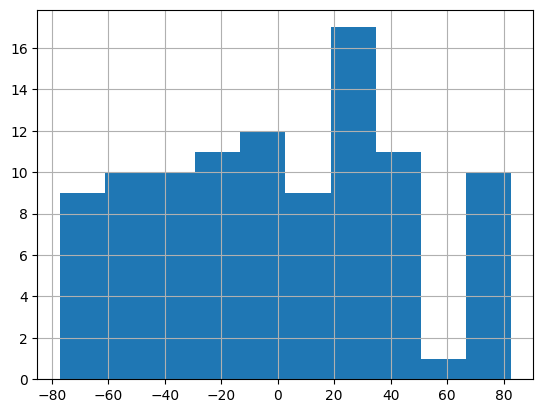

In [35]:
((df2 - df2.mean()).dot(np.array(pca.components_[0]))).hist()

In [36]:
# Showing that this is the same as the value we've called "v"
(df_example["v"] - (df2 - df2.mean()).dot(np.array(pca.components_[0]))).max()

np.float64(1.4210854715202004e-14)

### Linear Regression

Now let's run a linear regression model to predict the root from the height and width, as well as predicting the third principal component from the first and second.  Which is easier to predict?


#### **Answer**

I expect that the root from height and width will be easier to predict than the third principal component from the first and second, because principal components are orthogonal by design. This means that the first and second components should have no linear correlation with the third. As a result, predicting one principal component from others is inherently difficult using linear regression, since the dimensions of the PCs are constructed to be statistically independent (in terms of covariance).


### Predicting the root from the height and width

In [37]:
linreg = linear_model.LinearRegression()
linreg.fit(df2[['height', 'width']], df2['root'])
preds = linreg.predict(df2[['height', 'width']])
metrics.mean_squared_error(preds, df2['root']) # Mean squared error as a metric

138.22487356329611

In [38]:
np.corrcoef(preds, df2['root']) # Correlation coefficient as a metric

array([[1.        , 0.79468295],
       [0.79468295, 1.        ]])

### Predicting the third principal component from the first and second

In [39]:
first_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[0]))
second_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[1]))
third_principal_component_score = (df2 - df2.mean()).dot(np.array(pca3.components_[2]))

In [40]:
linreg_first = linear_model.LinearRegression()
pc_X = np.array([first_principal_component_score, second_principal_component_score]).T
linreg_first.fit(pc_X, third_principal_component_score)
preds = linreg_first.predict(pc_X)
metrics.mean_squared_error(preds, third_principal_component_score) # The mean squared error is a bit smaller here.

78.74928905273174

In [41]:
np.corrcoef(preds, third_principal_component_score) # More importantly, the correlation is basically zero

array([[1.00000000e+00, 1.89578845e-15],
       [1.89578845e-15, 1.00000000e+00]])

Here, we see that the projections of the first two principal components have no ability to predict the projection of the third, when measured by correlation.  This is a special property of principal components.  It is intended to ensure that the each component gives new information not present in the previous components.

The mean_squared_error is misleading - it makes it look like the error is less for the second computation than the first; but the correlation coefficient is giving more useful information here.  We cannot compare the mean squared error for two totally different computations, because mean squared error is highly dependent on the magnitudes of the values in question!

___

# 2. Weekly graph question

The tree data above can be graphed via either a pairplot or a bubble plot.  What are the advantages and disadvantages of each?

**Answer**

**Pairplot:**
The advantage of a pairplot is that it explicitly shows the relationship that each variable in the dataset has with every other variable. (In this instance: height-to-root correlations, root-to-width correlations, etc., in isolation.) This can be especially helpful if the dataset contains more than three dimensions (say, 10 or more). In such cases, the pairplot allows us to quickly scan how each pair of features relates to one another, helping identify which relationships might be worth further investigation.

The main disadvantage is that each subplot only shows two variables at a time (e.g., height vs. width). So in this particular example, where we only have three dimensions, the pairplot allows us to explore pairwise relationships, but it does not show how all three features interact together in a single plot.

**Bubble Plot:**
The advantage of a bubble plot is that it visualizes all three feature variables in the same plot. (In this case: width, height, and root size — with the third variable represented by bubble size.) This provides a more integrated view of how the three features behave together.

A disadvantage, however, is that you’re limited in how you assign variables to axes and bubble size — you’re essentially “locked into” one configuration. This means you don’t get the full range of pairwise combinations as you do with a pairplot.

Another disadvantage is that the third variable (bubble size) can be hard to perceive if the data range is small. For example, if all the root sizes are close in value, then the bubbles will look very similar — making it hard to visually distinguish meaningful differences in that third variable.

Text(0, 0.5, 'width of branches')

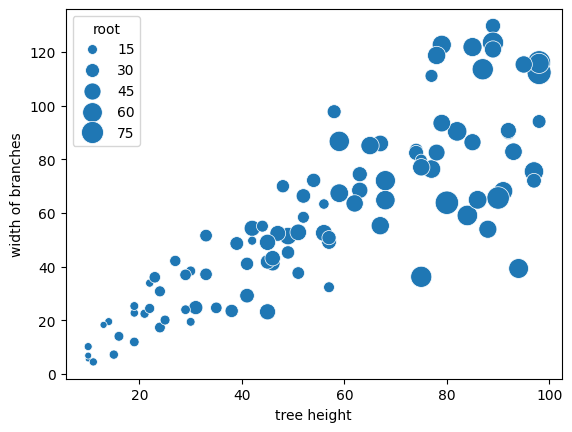

In [42]:
ax = sns.scatterplot(data = df2, x = "height", y = "width", size = "root", sizes = (minroot / maxroot * maxbubble, maxbubble))
ax.set_xlabel("tree height")
ax.set_ylabel("width of branches")

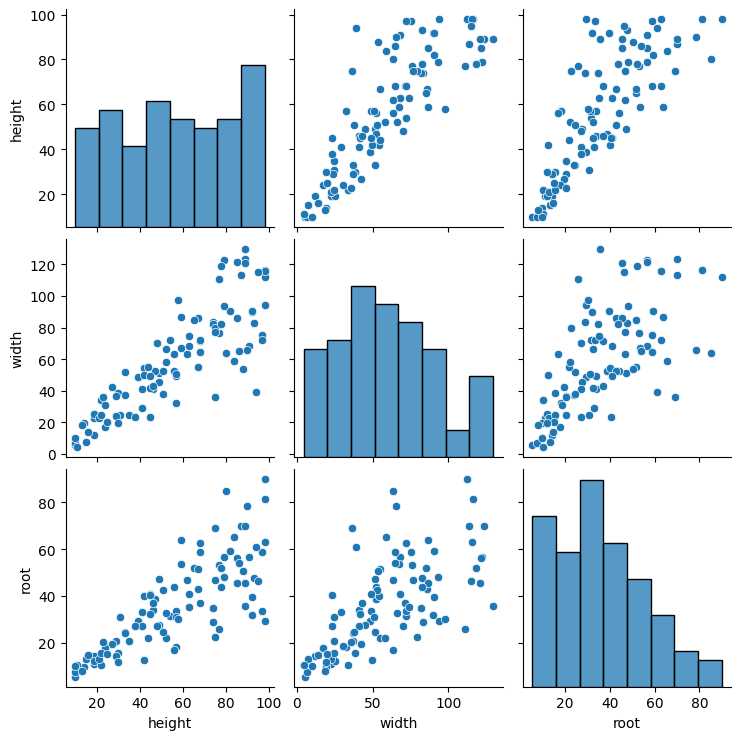

In [43]:
sns.pairplot(df2)

___

# 3. Homework - Grocery Store Correlation

In a particular state, the price of milk is highly correlated with the price of cheese.  Neither is correlated with the price of bread.

In [80]:
num_points = 1000
np.random.seed(0)
milk_series = np.maximum(np.random.normal(scale = 0.5, loc = 2.00, size = num_points), 1)
cheese_series = milk_series * np.maximum(np.random.normal(scale = 0.1, loc = 1.00, size = num_points), 0.5)
bread_series = np.maximum(np.random.normal(scale = 1.0, loc = 3.00, size = num_points), 1)
df3 = pd.DataFrame({"milk": milk_series, "cheese": cheese_series, "bread": bread_series})

In [81]:
df3

,milk,cheese,bread
0,2.882026,3.042256,1.467079
1,2.200079,2.396430,1.288030
2,2.489369,2.384239,3.046135
3,3.120447,3.153122,2.041626
4,2.933779,3.000685,2.919188
...,...,...,...
995,2.206435,2.228003,5.079177
996,1.900801,2.167202,2.092534
997,2.047096,2.079529,2.807596
998,1.426195,1.263337,1.787484


### Heatmap

Draw a heatmap where the x-axis category is a discretized version of the milk price and the y-axis category is a discretized version of the cheese price.  That is, you can choose "low", "medium", and "high" for the milk price, or, if you prefer, you can choose 1, 2, 3, 4, and 5 for the five quintiles.  (The first quintile should include the bottom fifth of the data, the second quintile contains the next fifth, and so on).

Try Googling "how do I change numerical to categorical data" to get advice on this.

In [92]:
heatmap_df = df3.copy()

heatmap_df['categorical_milk'] = pd.cut(df3['milk'], bins=5, labels=[1,2,3,4,5])
heatmap_df['categorical_cheese'] = pd.cut(df3['cheese'], bins=5, labels=[1,2,3,4,5])

heatmap_data = pd.crosstab(heatmap_df['categorical_cheese'], heatmap_df['categorical_milk'])


In [91]:
heatmap_data

categorical_milk,1,2,3,4,5
categorical_cheese,,,,,
1,117,14,0,0,0
2,34,280,77,0,0
3,0,42,234,72,2
4,0,0,17,71,16
5,0,0,0,5,19


Text(0.5, 1.0, 'Heatmap of Cheese vs. Milk Prices (Binned)')

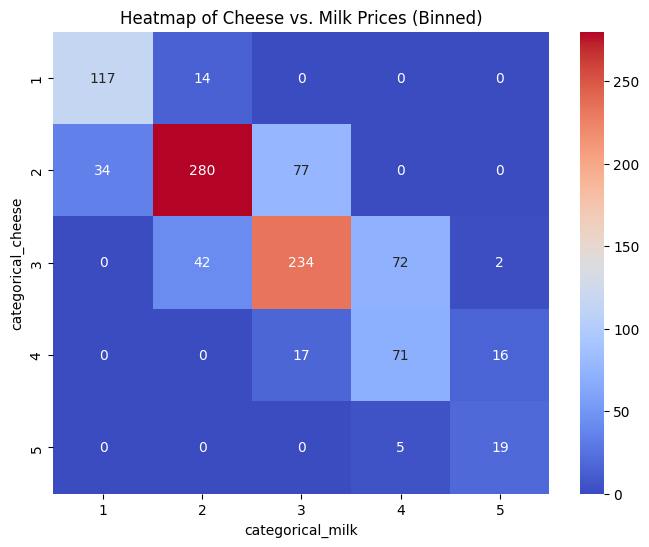

In [94]:
plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='d')
plt.title('Heatmap of Cheese vs. Milk Prices (Binned)')

___

### Bubble plot

Try all three possible bubble plots: one where the size of the dot is determined by the milk price, one where it's the cheese price, and one where it's the bread price.  Which of these plots is / are the most informative and useful? **Answer at Bottom**

**Size: Cheese**

Text(0, 0.5, 'bread price')

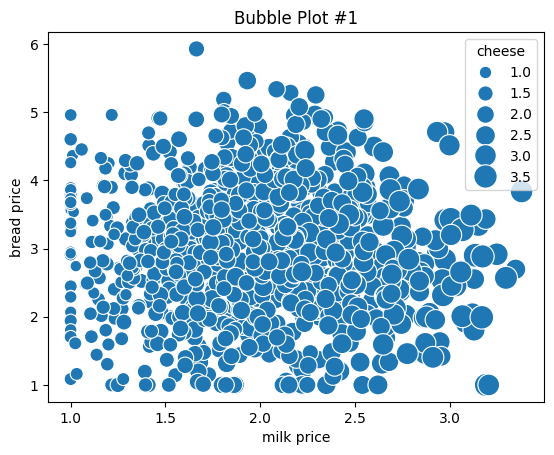

In [102]:
mincheese = df3['cheese'].min()
maxcheese = df3['cheese'].max()
maxbubble = 300

bp1 = sns.scatterplot(data = df3, x = "milk", y = "bread", size = "cheese", sizes = (mincheese / maxcheese * maxbubble, maxbubble))
plt.title("Bubble Plot #1")
bp1.set_xlabel("milk price")
bp1.set_ylabel("bread price")

**Size: Milk**

Text(0, 0.5, 'bread price')

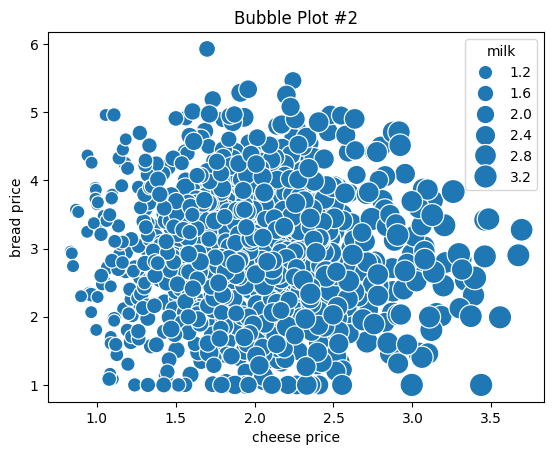

In [103]:
minmilk = df3['milk'].min()
maxmilk = df3['milk'].max()
maxbubble = 300

bp2 = sns.scatterplot(data = df3, x = "cheese", y = "bread", size = "milk", sizes = (minmilk / maxmilk * maxbubble, maxbubble))
plt.title("Bubble Plot #2")
bp2.set_xlabel("cheese price")
bp2.set_ylabel("bread price")

**Size: Bread**

Text(0, 0.5, 'milk price')

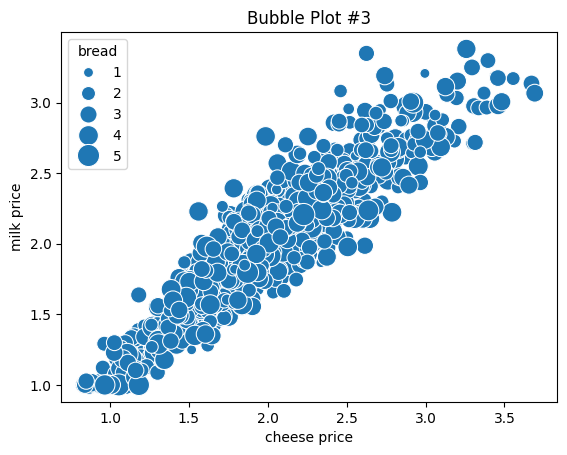

In [101]:
minbread = df3['bread'].min()
maxbread = df3['bread'].max()
maxbubble = 300

bp3 = sns.scatterplot(data = df3, x = "cheese", y = "milk", size = "bread", sizes = (minbread / maxbread * maxbubble, maxbubble))
plt.title("Bubble Plot #3")
bp3.set_xlabel("cheese price")
bp3.set_ylabel("milk price")

#### **Answer to: Which of these is most Useful?**

The Cheese vs. Milk with the Bubble size (Bubble Plot #3) was the most useful in terms of interpretability. This is because Cheese Price and Milk Price were correlated, so this made the 1st and 2nd axis (x, and y) easier to read. 

In this case, while the third axis, bubble size (representing the break price) is all over the place, it does not detract from the interpretability of the milk and cheese prices -- a condition that clearly effected the first two plots.  

___

### Principal component analysis

Perform a principal component analysis of the data.  What are the first, second, and third component vectors? **Answer at bottom**

Challenge question: explain why the three vectors point as they do.  (Could someone have guessed the order of the three vectors, even before running the analysis?) **Answer at bottom**

In [109]:
df3

,milk,cheese,bread
0,2.882026,3.042256,1.467079
1,2.200079,2.396430,1.288030
2,2.489369,2.384239,3.046135
3,3.120447,3.153122,2.041626
4,2.933779,3.000685,2.919188
...,...,...,...
995,2.206435,2.228003,5.079177
996,1.900801,2.167202,2.092534
997,2.047096,2.079529,2.807596
998,1.426195,1.263337,1.787484


#### **Answer: Print out of the Component Vectors**

(Sorry, you're going to have to expand the scrollable element to see it all)

In [137]:
pca_grocery = decomposition.PCA(n_components=3)
pca_grocery.fit(df3)

# Print explained variance
print("Explained Variance Ratio of the First Three Components:")
for i, ratio in enumerate(pca_grocery.explained_variance_ratio_, 1):
    print(f"  Component {i}: {ratio:.4f}")
print()

# Print Component Matrix
print("Principal Component Coefficient Matrix (Each row is a component vector): \n")
pc_componenets = pd.DataFrame(pca_grocery.components_, 
                                columns=['milk', 'cheese', 'bread'],
                                index=['PC1', 'PC2', 'PC3'])
print(pc_componenets)
print()


# Print Mean Values
mu_1, mu_2, mu_3 = df3.mean().values
print("Mean Prices:")
print(f" Mean  Milk:   {mu_1:.3f}")
print(f" Mean  Cheese: {mu_2:.3f}")
print(f" Mean  Bread:  {mu_3:.3f}")
print()
print()

# Reconstructing the principal components in readable form
pc1, pc2, pc3 = pca_grocery.components_
a, b, c = pc1
d, e, f = pc2
h, i, j = pc3

# Reconstructing Component Vector 1
print("Component Vector 1 (First Principal Component Approximation Formula):\n")
print(f"  v1 = ({a:.3f}) * (milk - {mu_1:.3f})")
print(f"     + ({b:.3f}) * (cheese - {mu_2:.3f})")
print(f"     + ({c:.3f}) * (bread - {mu_3:.3f})")
print(f"  point ≈ v1 * ({a:.3f}, {b:.3f}, {c:.3f}) + ({mu_1:.3f}, {mu_2:.3f}, {mu_3:.3f})\n")

# Reconstructing Component Vector 2
print("Component Vector 2 (Second Principal Component Approximation Formula):\n")
print(f"  v2 = ({d:.3f}) * (milk - {mu_1:.3f})")
print(f"     + ({e:.3f}) * (cheese - {mu_2:.3f})")
print(f"     + ({f:.3f}) * (bread - {mu_3:.3f})")
print(f"  point ≈ v2 * ({d:.3f}, {e:.3f}, {f:.3f}) + ...\n")

# Reconstructing Component Vector 3
print("Component Vector 3 (Third Principal Component Approximation Formula):\n")
print(f"  v3 = ({h:.3f}) * (milk - {mu_1:.3f})")
print(f"     + ({i:.3f}) * (cheese - {mu_2:.3f})")
print(f"     + ({j:.3f}) * (bread - {mu_3:.3f})")
print(f"  point ≈ v3 * ({h:.3f}, {i:.3f}, {j:.3f}) + ...\n")

Explained Variance Ratio of the First Three Components:
  Component 1: 0.6375
  Component 2: 0.3486
  Component 3: 0.0139

Principal Component Coefficient Matrix (Each row is a component vector): 

         milk    cheese     bread
PC1 -0.038256 -0.038095  0.998542
PC2  0.678738  0.732396  0.053945
PC3  0.733383 -0.679812  0.002162

Mean Prices:
 Mean  Milk:   1.982
 Mean  Cheese: 1.983
 Mean  Bread:  2.956


Component Vector 1 (First Principal Component Approximation Formula):

  v1 = (-0.038) * (milk - 1.982)
     + (-0.038) * (cheese - 1.983)
     + (0.999) * (bread - 2.956)
  point ≈ v1 * (-0.038, -0.038, 0.999) + (1.982, 1.983, 2.956)

Component Vector 2 (Second Principal Component Approximation Formula):

  v2 = (0.679) * (milk - 1.982)
     + (0.732) * (cheese - 1.983)
     + (0.054) * (bread - 2.956)
  point ≈ v2 * (0.679, 0.732, 0.054) + ...

Component Vector 3 (Third Principal Component Approximation Formula):

  v3 = (0.733) * (milk - 1.982)
     + (-0.680) * (cheese - 1.983

**Answer Discussion**

**part 1**
- First Principal Component (PC1):
    - PC1 = -0.038 * milk + (-0.038) * cheese + 0.999 * bread
- Second Principal Component (PC2):
    - PC2 = 0.679 * milk + 0.732 * cheese + 0.054 * bread
- Third Principal Component (PC3):
    - PC3 = 0.733 * milk - 0.680 * cheese + 0.002 * bread

**part 2**


The first component points almost entirely in the direction of the bread (.99), with a very small influence from milk and cheese, this is likely due to the price of bread having a much higher range (the mean is also close to 50% more than that of the other two) and is the most independent variable in the dataset. 

The second componenet is dominated by both the milk and cheese variables and has positive coefficients for both. This component is most likely capturing the variance that these two variables are responsible for (both correlated and similar in price)

The third component is again dominated by milk and cheese but this time it has differing coefficients ( positive vs. negative) this is most likely capturing the variation between these two varaibles. 


___

### Linear regression

Use linear regression to predict the milk price from the other two, the cheese price from the other two, and the bread price from the other two.  Which prediction(s) work the best, and why? **Answer at bottom**

In [ ]:
# Spin up 3 models
milkreg = linear_model.LinearRegression()
cheesereg = linear_model.LinearRegression()
breadreg = linear_model.LinearRegression()


In [146]:
# Data Pre Processing Milk 
milkregdata = df3.copy()
milkreg_features = milkregdata.drop(columns='milk', axis=1)
milkreg_target = milkregdata['milk'] 

# Train Milk Prediction Model 
train_milk = milkreg.fit(milkreg_features, milkreg_target)
milk_predictions = milkreg.predict(milkreg_features)
Milk_MSE = metrics.mean_squared_error(milk_predictions, milkreg_target)

# Milk Model Accuracy
print(f" The RMSE of the Milk Predictions is: {np.sqrt(Milk_MSE):.3f}")


# Cheese Model 
cheeseregdata = df3.copy()
cheesereg_features = cheeseregdata.drop(columns='cheese', axis=1)
cheesereg_target = cheeseregdata['cheese'] 

# Train cheese Prediction Model 
train_cheese = cheesereg.fit(cheesereg_features, cheesereg_target)
cheese_predictions = cheesereg.predict(cheesereg_features)
cheese_MSE = metrics.mean_squared_error(cheese_predictions, cheesereg_target)

# cheese Model Accuracy
print(f" The RMSE of the Cheese Predictions is: {np.sqrt(cheese_MSE):.3f}")



# Bread Model
breadregdata = df3.copy()
breadreg_features = breadregdata.drop(columns='bread', axis=1)
breadreg_target = breadregdata['bread'] 

# Train bread Prediction Model 
train_bread = breadreg.fit(breadreg_features, breadreg_target)
bread_predictions = breadreg.predict(breadreg_features)
bread_MSE = metrics.mean_squared_error(bread_predictions, breadreg_target)

# bread Model Accuracy
print(f" The RMSE of the Bread Predictions is: {np.sqrt(bread_MSE):.3f}")

 The RMSE of the Milk Predictions is: 0.186
 The RMSE of the Cheese Predictions is: 0.199
 The RMSE of the Bread Predictions is: 0.937


#### **Linear Regression Answer**

I would've wagered that the best model would be a tie between the milk and the cheese models (predicting milk from cheese price and cheese from milk price) because those two variables are strongly correlated, but bread is not correlated to either of them. In practice, the Milk model is slightly better (with ~ a 1 cent difference in their relative predictive powers) but I would assume that this is due to random variations in the data and the LinearRegression predictions. 

This is in contrast to the 'bread' prediction model which attempts to predict the price of bread from the price of milk and cheese -- This would not be a good model because the two feature variables in this case, cheese and milk, are not correlated to the price of bread, so in essence, this would always be worse than the other two. 

___

# 4. Storytelling With Data plot



#### **Replication of the 'Use of Color' plots on page 124**

Reproduce any graph of your choice in p. 120-135 of the Storytelling With Data book as best you can.  ("Use color consistently" in chapter four up to "Create a clear visual hierarchy of information" in chapter five.)    You do not have to get the exact data values right, just the overall look and feel.

In [147]:
df3

,milk,cheese,bread
0,2.882026,3.042256,1.467079
1,2.200079,2.396430,1.288030
2,2.489369,2.384239,3.046135
3,3.120447,3.153122,2.041626
4,2.933779,3.000685,2.919188
...,...,...,...
995,2.206435,2.228003,5.079177
996,1.900801,2.167202,2.092534
997,2.047096,2.079529,2.807596
998,1.426195,1.263337,1.787484


In [164]:
final_datagraph = df3.mean().reset_index()
final_datagraph.columns = ['Item', 'Price']

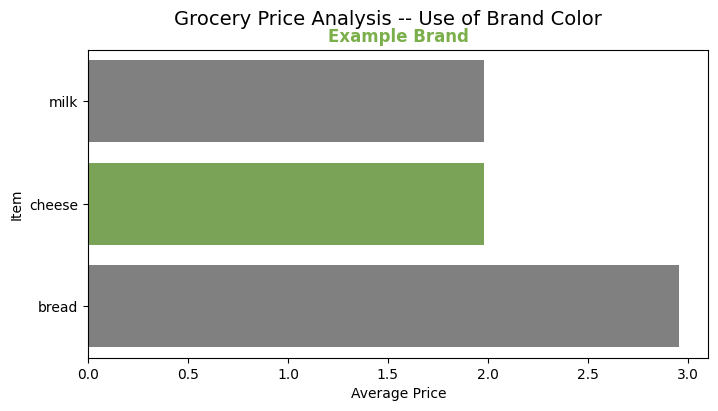

In [196]:
# Set Colors
colors = ['gray' if item != 'cheese' else '#7BAF4B' for item in final_datagraph['Item']]  # green for cheese

plt.figure(figsize=(8, 4))
sns.barplot(data=final_datagraph, x='Price', y='Item', palette=colors)
plt.suptitle("Grocery Price Analysis -- Use of Brand Color", fontsize=14, color='black')  
plt.title("Example Brand", fontsize=12, color='#7BAF4B', fontweight='bold')  
plt.xlabel("Average Price")
plt.ylabel("Item")
plt.show()


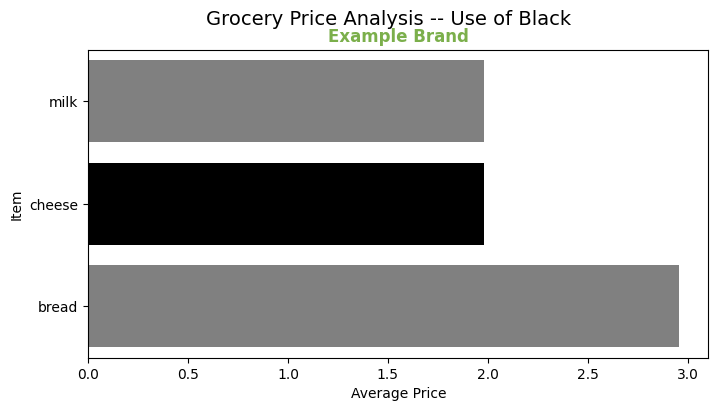

In [195]:
# Set Colors
colors = ['grey' if item != 'cheese' else 'black' for item in final_datagraph['Item']]  # green for cheese

plt.figure(figsize=(8, 4))
sns.barplot(data=final_datagraph, x='Price', y='Item', palette=colors)
plt.suptitle("Grocery Price Analysis -- Use of Black", fontsize=14, color='black')  
plt.title("Example Brand", fontsize=12, color='#7BAF4B', fontweight='bold')  
plt.xlabel("Average Price")
plt.ylabel("Item")
plt.show()

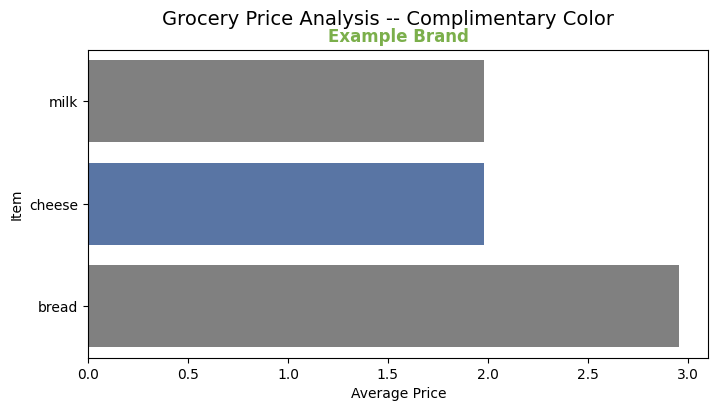

In [ ]:
# Set Colors
colors = ['grey' if item != 'cheese' else '#4C72B0' for item in final_datagraph['Item']]  

plt.figure(figsize=(8, 4))
sns.barplot(data=final_datagraph, x='Price', y='Item', palette=colors)
plt.suptitle("Grocery Price Analysis -- Complimentary Color", fontsize=14, color='black')  
plt.title("Example Brand", fontsize=12, color='#7BAF4B', fontweight='bold')  
plt.xlabel("Average Price")
plt.ylabel("Item")
plt.show()